In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import asarray
from PIL import Image
import pathlib
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
import seaborn as sns
from sklearn.manifold import TSNE

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
# Hyper-parameters
num_epochs = 20
batch_size = 64
learning_rate = 0.005

#Model Parameters
num_features = 20

In [3]:
dataset = ImageFolder("/Users/karthikd1054/Documents/COMP 6721/Project/plant_leaf_dataset/dataset1", transform=Compose(
    [ToTensor(),
     Resize((224, 224)),
     Normalize(mean = [0.485, 0.456, 0.406], std =  [0.229, 0.224, 0.225])
    ]))
dataset, testDataset=torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])
trainDataset, validationDataset = torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])

trainingDataLoader = DataLoader(
    trainDataset,
    batch_size=batch_size,
    shuffle=True
)

validationDataLoader = DataLoader(
    validationDataset,
    batch_size=batch_size,
    shuffle=False
)

testingDataLoader = DataLoader(
    testDataset,
    batch_size=batch_size,
    shuffle=False
)

#Write code to display the images in each dataloader

In [4]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_features)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
print(device)

mps


In [6]:
total_steps = len(trainingDataLoader)

batchwiseTrainAccuracyLog = []
batchwiseTrainLossLog = []

epochwiseTrainAccuracyLog = []
epochwiseTrainLossLog = []

batchwiseValAccuracyLog = []
batchwiseValLossLog = []

epochwiseValAccuracyLog = []
epochwiseValLossLog = []

for epoch in range(num_epochs):

    total_label_count = 0

    accumulated_train_loss=0
    accumulated_validation_loss=0

    accumulated_train_accuracy=0
    accumulated_validation_accuracy=0

    inner_loop_counter_train=0
    model.train()
    for i, data in enumerate(trainingDataLoader):
        inner_loop_counter_train+=1

        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_train_accuracy += (predicted == labels).sum().item()
        accumulated_train_loss+=loss.item()
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.7f}, Accuracy: {:.4f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            batchwiseTrainAccuracyLog.append((correct / total) * 100)
            batchwiseTrainLossLog.append(loss.item())
    training_accuracy = accumulated_train_accuracy / total_label_count
    epochwiseTrainAccuracyLog.append(training_accuracy)
    print(f'EPOCH {epoch + 1}.....................')
    print('Accuracy on training set: {}%'.format(100 * training_accuracy))
    epochwiseTrainLossLog.append(accumulated_train_loss/inner_loop_counter_train)

    #Evaluation using validation data

    total_label_count = 0

    inner_loop_counter_validation=0

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(validationDataLoader):
        inner_loop_counter_validation+=1

        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accumulated_validation_accuracy += (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_validation_loss+=loss.item()
        if (i + 1) % 10 == 0:
            batchwiseValAccuracyLog.append((correct / total) * 100)
            batchwiseValLossLog.append(loss.item())
    validation_accuracy = accumulated_validation_accuracy / total_label_count
    epochwiseValAccuracyLog.append(validation_accuracy)
    print('Accuracy on validation set: {}%'.format(100 * validation_accuracy))
    epochwiseValLossLog.append(accumulated_validation_loss/inner_loop_counter_validation)
print("Training Finished!")


Epoch [1/20], Step [10/267], Loss: 4.8570662, Accuracy: 14.0625%
Epoch [1/20], Step [20/267], Loss: 2.9080701, Accuracy: 12.5000%
Epoch [1/20], Step [30/267], Loss: 2.7904692, Accuracy: 10.9375%
Epoch [1/20], Step [40/267], Loss: 3.2934608, Accuracy: 14.0625%
Epoch [1/20], Step [50/267], Loss: 3.4300749, Accuracy: 9.3750%
Epoch [1/20], Step [60/267], Loss: 2.7310917, Accuracy: 3.1250%
Epoch [1/20], Step [70/267], Loss: 2.4138985, Accuracy: 23.4375%
Epoch [1/20], Step [80/267], Loss: 2.3556356, Accuracy: 23.4375%
Epoch [1/20], Step [90/267], Loss: 2.0629482, Accuracy: 28.1250%
Epoch [1/20], Step [100/267], Loss: 2.1919441, Accuracy: 20.3125%
Epoch [1/20], Step [110/267], Loss: 2.3865733, Accuracy: 17.1875%
Epoch [1/20], Step [120/267], Loss: 1.9328985, Accuracy: 35.9375%
Epoch [1/20], Step [130/267], Loss: 1.7414427, Accuracy: 29.6875%
Epoch [1/20], Step [140/267], Loss: 1.7782917, Accuracy: 35.9375%
Epoch [1/20], Step [150/267], Loss: 2.0165186, Accuracy: 25.0000%
Epoch [1/20], Step [1

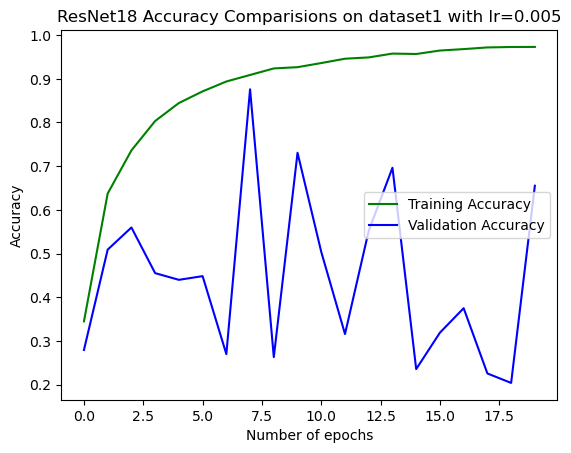

In [7]:
fig,ax=plt.subplots()
epochs_list = list(range(0,20))
ax.plot(epochs_list,epochwiseTrainAccuracyLog,'g',label='Training Accuracy')
ax.plot(epochs_list,epochwiseValAccuracyLog,'b',label='Validation Accuracy')
ax.plot()
ax.set_title('ResNet18 Accuracy Comparisions on dataset1 with lr='+str(learning_rate))
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

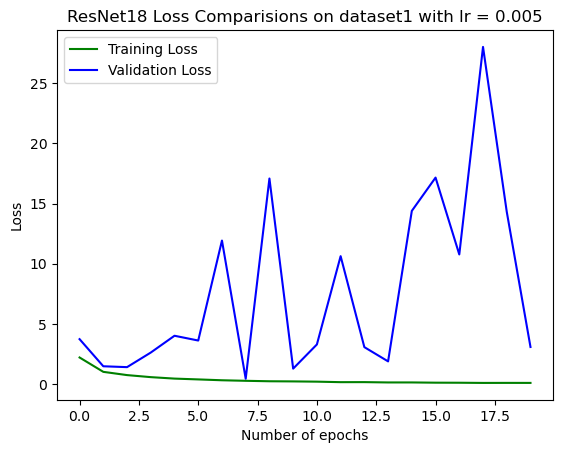

In [8]:
fig,ax=plt.subplots()
ax.plot(epochs_list,epochwiseTrainLossLog,'g',label='Training Loss')
ax.plot(epochs_list,epochwiseValLossLog,'b',label='Validation Loss')
ax.plot()
ax.set_title('ResNet18 Loss Comparisions on dataset1 with lr = '+str(learning_rate))
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

Accuracy on test set: 63.77217553688141%
Dataset 1 - Test Metrics
Accuracy: 63.87832699619772
Recall: 63.87832699619772
F-score: 63.84626541828007
Confusion Matrix:


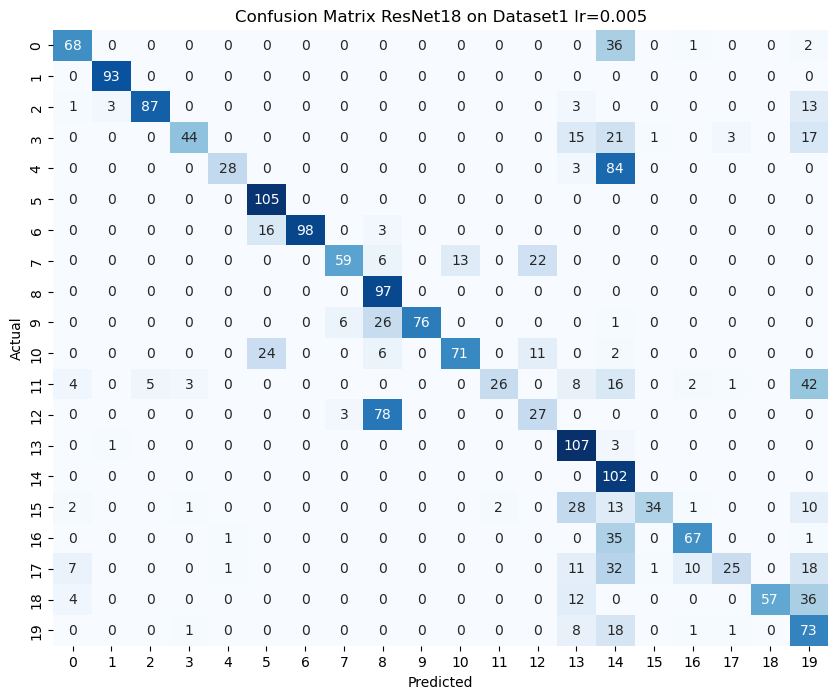

In [9]:
y_pred = []
groundtruth = []

model.eval()

testAccuracyLog = []
testLossLog = []

with torch.no_grad():

    inner_loop_counter_test = 0

    accumulated_test_accuracy=0
    accumulated_test_loss=0

    for images, labels in testingDataLoader:
        images = images.to(device)
        labels = labels.to(device)
        inner_loop_counter_test+=1
        test_loss=0
        outputs = model(images)
        test_loss=criterion(outputs,labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.append(predicted)
        groundtruth.append(labels)
        accumulated_test_loss+=test_loss.item()
    testLossLog.append(accumulated_test_loss/inner_loop_counter_test)
    test_accuracy=correct/total
    print('Accuracy on test set: {}%'.format(100 * test_accuracy))
    testAccuracyLog.append(test_accuracy)

predictions_np = [tensor.detach().cpu().numpy() for tensor in y_pred]
ground_truth_np = [tensor.detach().cpu().numpy() for tensor in groundtruth]

predictions_np = np.concatenate(predictions_np)
ground_truth_np = np.concatenate(ground_truth_np)

accuracy = accuracy_score(ground_truth_np, predictions_np)
recall = recall_score(ground_truth_np, predictions_np, average='weighted')
conf_matrix = confusion_matrix(ground_truth_np, predictions_np)
f_score = f1_score(ground_truth_np, predictions_np, average='weighted')

print("Dataset 1 - Test Metrics\nAccuracy:", accuracy*100)
print("Recall:", recall*100)
print("F-score:", f_score*100)

print("Confusion Matrix:")

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ResNet18 on Dataset1 lr='+str(learning_rate))
plt.show()

In [10]:
#Plotting Datapoints using TSNE

prediction_list=[]
labels_list=[]
with torch.inference_mode():
  for images, labels in testingDataLoader:
    images=images.to(device)
    labels=labels.to(device)
    outputs = model(images)
    prediction_list.append(outputs.cpu())
    labels_list.append(labels.cpu())

Y_pred=torch.cat(prediction_list).numpy()
y_test=torch.cat(labels_list).numpy()

tsne=TSNE(n_components=2,random_state=42)
embedding_2d=tsne.fit_transform(Y_pred)

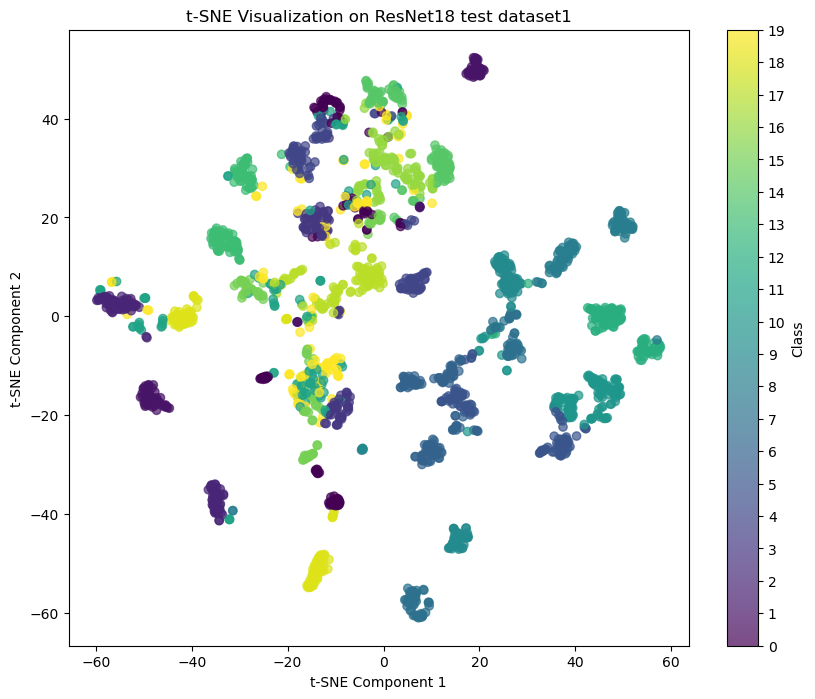

In [11]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter,ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],label='Class')
plt.title('t-SNE Visualization on ResNet18 test dataset1')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
#plt.savefig('Dataset2_ShuffleNet_TSNE_lr005.png')
#files.download('Dataset2_ShuffleNet_TSNE_lr005.png')
plt.show()

In [12]:

prediction_list=[]
labels_list=[]
with torch.inference_mode():
  for images, labels in trainingDataLoader:
    images=images.to(device)
    labels=labels.to(device)
    outputs = model(images)
    prediction_list.append(outputs.cpu())
    labels_list.append(labels.cpu())

Y_pred=torch.cat(prediction_list).numpy()
y_test=torch.cat(labels_list).numpy()

tsne=TSNE(n_components=2,random_state=42)
embedding_2d=tsne.fit_transform(Y_pred)

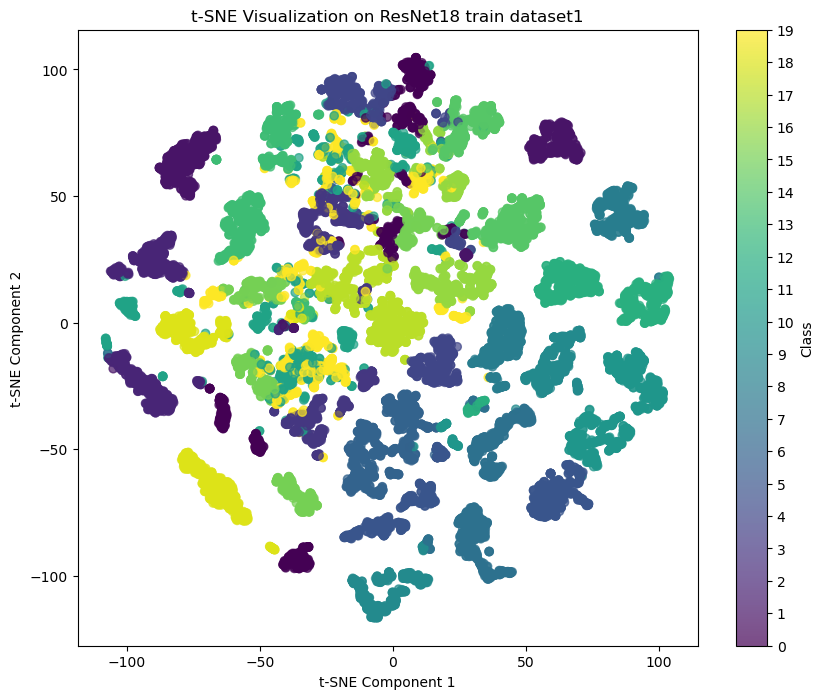

In [13]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter,ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],label='Class')
plt.title('t-SNE Visualization on ResNet18 train dataset1')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
#plt.savefig('Dataset2_ShuffleNet_TSNE_lr005.png')
#files.download('Dataset2_ShuffleNet_TSNE_lr005.png')
plt.show()